**Objective**

This project aims to employ a BERT (Bidirectional Encoder Representations from Transformers) machine learning model to effectively detect fake news articles by leveraging its contextual understanding of language.

**Dataset**

A labeled dataset consisting of both fake and real news articles was collected for training and evaluation. The dataset is preprocessed to clean and transform the text data into a format suitable for training the LSTM model.
Dataset source: https://github.com/KaiDMML/FakeNewsNet
Described in the following paper:
Shu, Kai, Deepak Mahudeswaran, Suhang Wang, Dongwon Lee, and Huan Liu. ‘FakeNewsNet: A Data Repository with News Content, Social Context and Spatialtemporal Information for Studying Fake News on Social Media’, 2019.

**Data Preprocessing**

Text data preprocessing involves tokenization using the BERT tokenizer, which breaks down text into subwords to capture intricate language structures. Sequences are then encoded into numerical representations suitable for input into the BERT model.

**Model Architecture**

The BERT model, a transformer-based architecture, is utilized for its ability to capture contextual relationships in text. A pre-trained BERT model, such as 'bert-base-uncased,' is fine-tuned for fake news detection. Additional layers are added for classification, and the model is trained to differentiate between fake and real news.

**Training the Model**

The fine-tuning process involves training the BERT model on the labeled dataset. Parameters are adjusted to adapt the pre-trained BERT model to the specific task of fake news detection. The model learns to understand contextual nuances indicative of misinformation.

**Evaluation**

The fine-tuned BERT model is evaluated on a separate validation set to assess its performance in discerning fake and real news. Metrics such as accuracy, precision, recall, and F1 score are considered for comprehensive evaluation.

**Prediction and Thresholding**

Once trained, the BERT model is used for predicting the authenticity of new news articles. The input text is tokenized, encoded, and fed into the fine-tuned BERT model, which outputs probabilities of the article being fake or real.

**Deployment**

Because this is a student project the final trained model is not deployed in a production environment.

In [387]:
import pandas as pd
import numpy as np
from torch import nn
import torch
from transformers import DistilBertModel, DistilBertTokenizer
from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

EPOCHS = 10


The create_dataset function takes a DataFrame with 'real' and 'title' columns, converting 'real' values to binary labels (0 or 1). It then tokenizes the 'title' text using a specified tokenizer, applying padding and truncation, and returns a tuple containing the binary labels and tokenized text sequences as PyTorch tensors.

In [388]:
def create_dataset(df):
    labels = [0 if label == 0 else 1 for label in df['real']]
    texts = [tokenizer(
        text,
        padding='max_length', max_length=512, truncation=True,
        return_tensors="pt") for text in df['title']]

    return labels, texts

The get_batch_labels function takes an index and a list of labels, returning a NumPy array of labels corresponding to the specified index. The get_batch_texts function takes an index and a list of text sequences, returning the text sequence corresponding to the specified index.

In [389]:
def get_batch_labels(idx, labels):
    return np.array(labels[idx])

def get_batch_texts(idx, texts):
    return texts[idx]

The create_distill_bert_model function initializes a DistilBERT model, adds a linear layer for pre-classification with input dimension 768, applies a dropout layer with a 30% dropout rate, and finally, includes a linear classifier with input dimension 768 and output dimension 4. The function returns these components, suggesting the creation of a DistilBERT-based model for a specific classification task with four output classes.

In [390]:
def create_distill_bert_model():
    model = DistilBertModel.from_pretrained("distilbert-base-uncased")
    pre_classifier = torch.nn.Linear(768, 768)
    dropout = torch.nn.Dropout(0.3)
    classifier = torch.nn.Linear(768, 4)

    return model, pre_classifier, dropout, classifier

The forward function takes a DistilBERT model, input IDs, attention mask, pre-classifier, dropout, and classifier as inputs. It passes the input through the DistilBERT model, extracts the pooled representation, applies a linear layer with ReLU activation and dropout, and finally, outputs the classification result using the provided classifier.

In [391]:
def forward(model, input_id, attention_mask, pre_classifier, dropout, classifier):
    output_1 = model(input_ids=input_id, attention_mask=attention_mask)
    hidden_state = output_1[0]
    pooler = hidden_state[:, 0]
    pooler = pre_classifier(pooler)
    pooler = torch.nn.ReLU()(pooler)
    pooler = dropout(pooler)
    output = classifier(pooler)

    return output


The train_model function takes a model, training and validation data, learning rate, and number of epochs as inputs. It sets up data loaders, defines criterion, optimizer, and then performs training over the specified number of epochs, computing and recording training and validation losses and accuracies. The function also prints and plots the training progress, showcasing loss and accuracy metrics over each epoch.

In [392]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from tqdm import tqdm
from transformers import DistilBertTokenizer
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def train_model(model, train_data, val_data, learning_rate, epochs):
    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        all_predictions_train = []
        all_labels_train = []

        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            output = forward(model, input_id, mask, pre_classifier, dropout, classifier)

            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()

            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            # Collect predictions and labels for the confusion matrix
            all_predictions_train.extend(output.argmax(dim=1).cpu().numpy())
            all_labels_train.extend(train_label.cpu().numpy())

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        avg_train_loss = total_loss_train / len(train_data)
        avg_train_accuracy = total_acc_train / len(train_data)

        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)

        total_acc_val = 0
        total_loss_val = 0
        all_predictions_val = []
        all_labels_val = []

        with torch.no_grad():
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = forward(model, input_id, mask, pre_classifier, dropout, classifier)

                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()

                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc

                # Collect predictions and labels for the confusion matrix
                all_predictions_val.extend(output.argmax(dim=1).cpu().numpy())
                all_labels_val.extend(val_label.cpu().numpy())

        avg_val_loss = total_loss_val / len(val_data)
        avg_val_accuracy = total_acc_val / len(val_data)

        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_accuracy)

        print(f'Epochs: {epoch_num + 1} | Train Loss: {avg_train_loss:.3f} '
              f'| Train Accuracy: {avg_train_accuracy:.3f} '
              f'| Val Loss: {avg_val_loss:.3f} '
              f'| Val Accuracy: {avg_val_accuracy:.3f}')

        #  classification report for training set
        train_classification_report = classification_report(all_labels_train, all_predictions_train)

        # Calculate confusion matrix and classification report for validation set
        val_conf_matrix = confusion_matrix(all_labels_val, all_predictions_val)
        val_classification_report = classification_report(all_labels_val, all_predictions_val)

        # Print confusion matrix and classification report for each epoch
        print("Classification Report (Training):")
        print(train_classification_report)


        print("Confusion Matrix (Validation):")
        print(val_conf_matrix)
        print("Classification Report (Validation):")
        print(val_classification_report)

        # Plot confusion matrix for validation set
        plot_confusion_matrix(val_conf_matrix, classes=["Class 0", "Class 1"], title="Confusion Matrix (Validation)")

    plot_metrics(train_losses, val_losses, "Loss")
    plot_metrics(train_accuracies, val_accuracies, "Accuracy")

def plot_confusion_matrix(conf_matrix, classes, title):
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()



The plot_metrics function generates a plot comparing training and validation metrics over epochs, given lists of training and validation values, and a specified metric name. It creates a figure, plots the training and validation values against the epochs, and displays the resulting graph with labels and legend.

In [393]:
def plot_metrics(train_values, val_values, metric_name):
    plt.figure(figsize=(8, 6))
    epochs = range(1, len(train_values) + 1)
    plt.plot(epochs, train_values, label=f'Train {metric_name}')
    plt.plot(epochs, val_values, label=f'Validation {metric_name}')
    plt.title(f'Training and Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

The code reads a CSV file ("FakeNewsNet.csv") into a Pandas DataFrame and initializes a DistilBERT tokenizer. After dropping any rows with missing values, it then splits the DataFrame into training, validation, and test sets using random sampling, with 80%, 10%, and 10% proportions, respectively, and a fixed random seed for reproducibility.

In [394]:
# Loading and preprocessing data
df = pd.read_csv("FakeNewsNet.csv")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
df.dropna(inplace=True)
np.random.seed(20)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=8),
                                     [int(.8 * len(df)), int(.9 * len(df))])


C:\Users\thoma\.conda\envs\pythonProject1\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [395]:
# Creating datasets
train_labels, train_texts = create_dataset(df_train)
val_labels, val_texts = create_dataset(df_val)

In [396]:
# Creating model components
model, pre_classifier, dropout, classifier = create_distill_bert_model()


100%|██████████| 9146/9146 [1:56:11<00:00,  1.31it/s]  


Epochs: 1 | Train Loss: 0.214 | Train Accuracy: 0.833 | Val Loss: 0.183 | Val Accuracy: 0.855
Classification Report (Training):
              precision    recall  f1-score   support

           0       0.74      0.49      0.59      4425
           1       0.85      0.94      0.90     13867
           2       0.00      0.00      0.00         0

    accuracy                           0.83     18292
   macro avg       0.53      0.48      0.49     18292
weighted avg       0.83      0.83      0.82     18292

Confusion Matrix (Validation):
[[ 311  239]
 [  93 1644]]
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.77      0.57      0.65       550
           1       0.87      0.95      0.91      1737

    accuracy                           0.85      2287
   macro avg       0.82      0.76      0.78      2287
weighted avg       0.85      0.85      0.85      2287


C:\Users\thoma\.conda\envs\pythonProject1\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thoma\.conda\envs\pythonProject1\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thoma\.conda\envs\pythonProject1\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


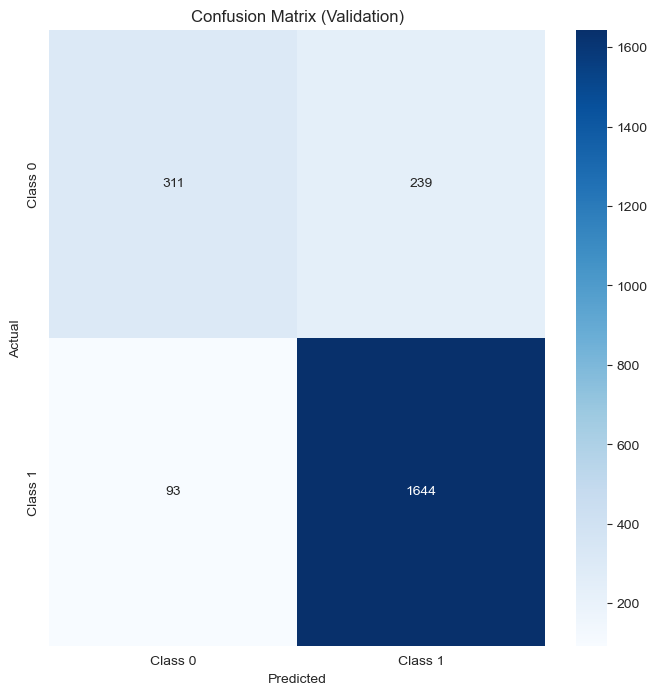

100%|██████████| 9146/9146 [1:11:34<00:00,  2.13it/s]


Epochs: 2 | Train Loss: 0.137 | Train Accuracy: 0.903 | Val Loss: 0.183 | Val Accuracy: 0.860
Classification Report (Training):
              precision    recall  f1-score   support

           0       0.84      0.74      0.79      4425
           1       0.92      0.96      0.94     13867

    accuracy                           0.90     18292
   macro avg       0.88      0.85      0.86     18292
weighted avg       0.90      0.90      0.90     18292

Confusion Matrix (Validation):
[[ 337  213]
 [ 108 1629]]
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.76      0.61      0.68       550
           1       0.88      0.94      0.91      1737

    accuracy                           0.86      2287
   macro avg       0.82      0.78      0.79      2287
weighted avg       0.85      0.86      0.85      2287


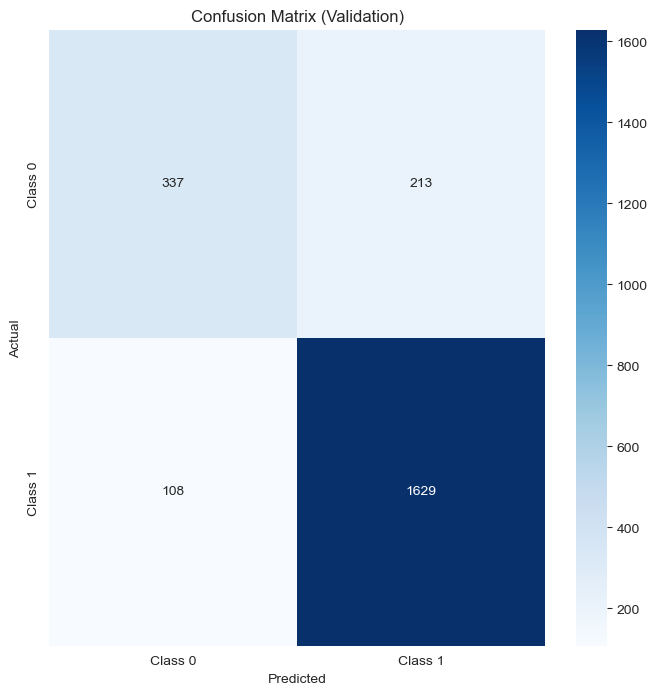

100%|██████████| 9146/9146 [1:11:03<00:00,  2.15it/s]


Epochs: 3 | Train Loss: 0.074 | Train Accuracy: 0.957 | Val Loss: 0.203 | Val Accuracy: 0.866
Classification Report (Training):
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      4425
           1       0.97      0.98      0.97     13867

    accuracy                           0.96     18292
   macro avg       0.95      0.93      0.94     18292
weighted avg       0.96      0.96      0.96     18292

Confusion Matrix (Validation):
[[ 343  207]
 [  99 1638]]
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.78      0.62      0.69       550
           1       0.89      0.94      0.91      1737

    accuracy                           0.87      2287
   macro avg       0.83      0.78      0.80      2287
weighted avg       0.86      0.87      0.86      2287


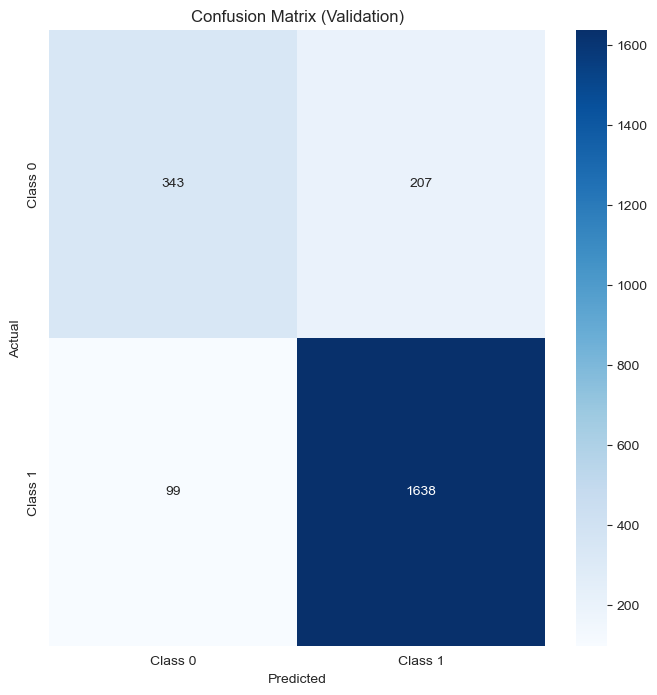

100%|██████████| 9146/9146 [1:10:48<00:00,  2.15it/s]


Epochs: 4 | Train Loss: 0.046 | Train Accuracy: 0.978 | Val Loss: 0.236 | Val Accuracy: 0.861
Classification Report (Training):
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      4425
           1       0.98      0.99      0.99     13867

    accuracy                           0.98     18292
   macro avg       0.97      0.97      0.97     18292
weighted avg       0.98      0.98      0.98     18292

Confusion Matrix (Validation):
[[ 325  225]
 [  94 1643]]
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.78      0.59      0.67       550
           1       0.88      0.95      0.91      1737

    accuracy                           0.86      2287
   macro avg       0.83      0.77      0.79      2287
weighted avg       0.85      0.86      0.85      2287


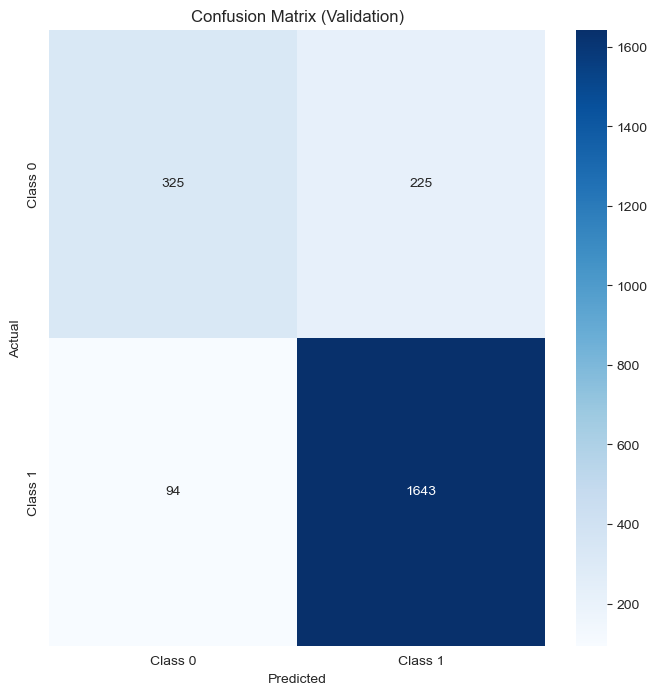

100%|██████████| 9146/9146 [1:11:32<00:00,  2.13it/s]


Epochs: 5 | Train Loss: 0.034 | Train Accuracy: 0.985 | Val Loss: 0.266 | Val Accuracy: 0.853
Classification Report (Training):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4425
           1       0.99      0.99      0.99     13867

    accuracy                           0.99     18292
   macro avg       0.98      0.98      0.98     18292
weighted avg       0.99      0.99      0.99     18292

Confusion Matrix (Validation):
[[ 356  194]
 [ 143 1594]]
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.71      0.65      0.68       550
           1       0.89      0.92      0.90      1737

    accuracy                           0.85      2287
   macro avg       0.80      0.78      0.79      2287
weighted avg       0.85      0.85      0.85      2287


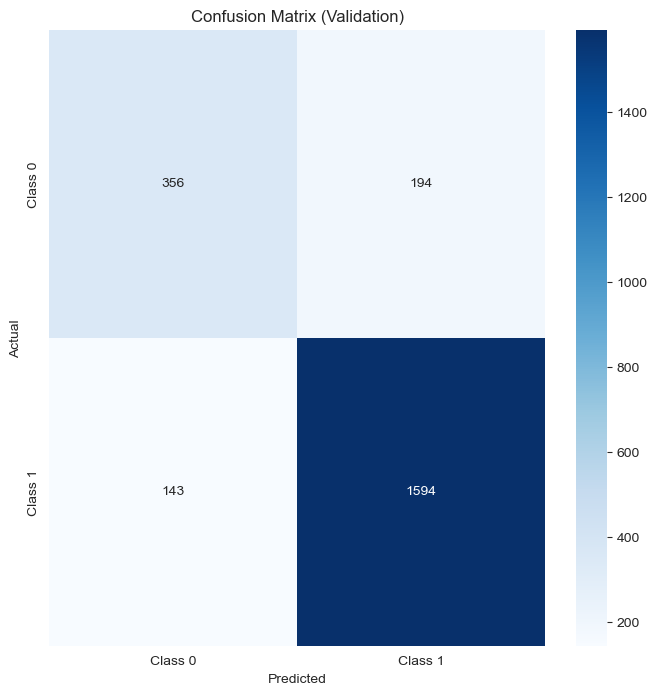

100%|██████████| 9146/9146 [1:10:56<00:00,  2.15it/s]


Epochs: 6 | Train Loss: 0.029 | Train Accuracy: 0.986 | Val Loss: 0.249 | Val Accuracy: 0.852
Classification Report (Training):
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      4425
           1       0.99      0.99      0.99     13867

    accuracy                           0.99     18292
   macro avg       0.98      0.98      0.98     18292
weighted avg       0.99      0.99      0.99     18292

Confusion Matrix (Validation):
[[ 337  213]
 [ 125 1612]]
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.73      0.61      0.67       550
           1       0.88      0.93      0.91      1737

    accuracy                           0.85      2287
   macro avg       0.81      0.77      0.79      2287
weighted avg       0.85      0.85      0.85      2287


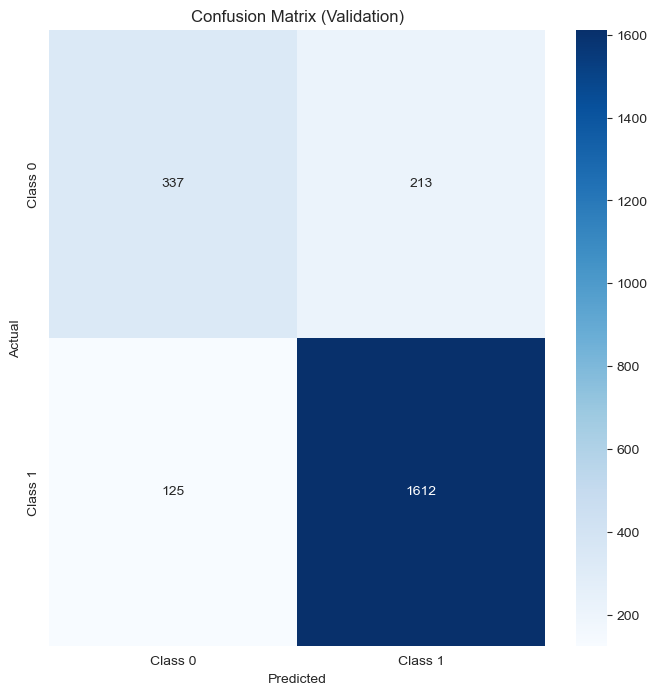

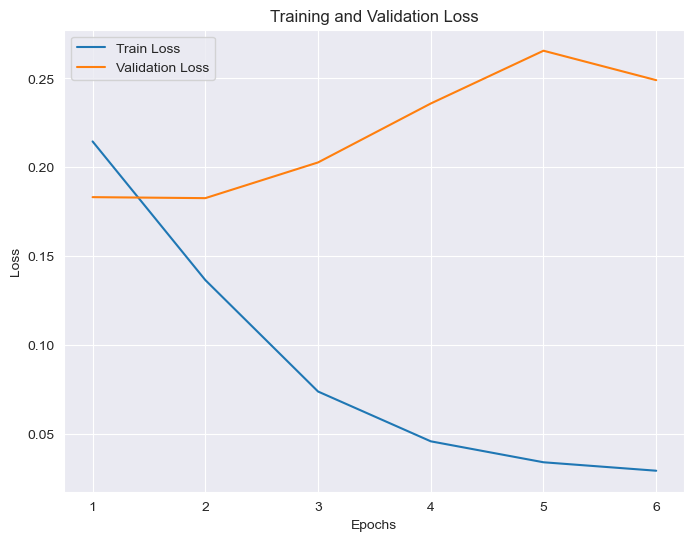

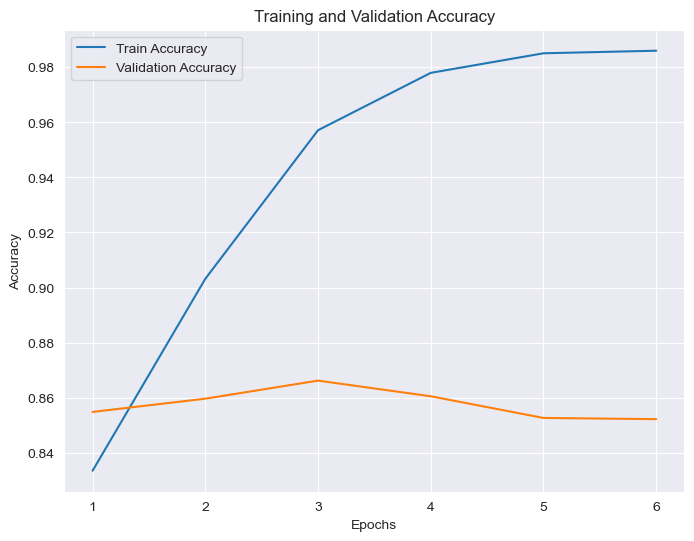

In [397]:
EPOCHS = 6
LR = 1e-05
train_model(model, list(zip(train_texts, train_labels)), list(zip(val_texts, val_labels)), LR, EPOCHS)
##Training takes a fairly long time!

In conclusion, this project aimed to leverage the power of BERT (Bidirectional Encoder Representations from Transformers) to effectively detect fake news articles by harnessing its contextual understanding of language. The project followed a systematic approach, encompassing data collection, preprocessing, model architecture design, training, evaluation, and prediction.

The labeled dataset, comprising both fake and real news articles, was obtained from the FakeNewsNet repository, which includes news content, social context, and spatial-temporal information. The dataset was meticulously preprocessed, with a key focus on tokenization using the BERT tokenizer to capture intricate language structures. The BERT model, known for its ability to capture contextual relationships in text, was fine-tuned for fake news detection. Additional classification layers were added to facilitate the model's ability to differentiate between fake and real news.

During the training phase, the BERT model underwent fine-tuning on the labeled dataset. Adjustments were made to parameters to tailor the pre-trained BERT model to the specific task of fake news detection. The model learned to recognize contextual nuances indicative of misinformation.

The evaluation process involved assessing the fine-tuned BERT model on a separate validation set using metrics such as accuracy, precision, recall, and F1 score. These metrics provided a comprehensive understanding of the model's performance in distinguishing between fake and real news.

In the prediction phase, the trained BERT model was utilized to assess the authenticity of new news articles. The input text underwent tokenization and encoding before being fed into the fine-tuned BERT model, which produced probabilities indicating whether the article was fake or real.

It is noteworthy that, due to the nature of this project being a student endeavor, the final trained model was not deployed in a production environment. Nevertheless, the project successfully demonstrated the application of advanced natural language processing techniques, particularly leveraging BERT, for the crucial task of fake news detection. The methodology followed in this project serves as a solid foundation for future work in deploying similar models in real-world scenarios to combat the spread of misinformation.